#Importing libraries:

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Creating the model

In [ ]:
# creating the model

###1. Creating Patch Embedding: convert the image into a 1D sequence learnable embedding vector

###### Uses Conv2d and flatten

In [ ]:
from torch import nn

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int = 3, patch_size:int = 16, embedding_dim:int=768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,  out_channels = embedding_dim, kernel_size = patch_size, stride = patch_size, padding = 0)  #output shape = (batch_size, 768, 14,14)
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3) # only flatten the feature map dimensions into a single vector  #output shape = (batch_size, 768, 196)

  def forward(self, x):

    image_resolution = x.shape[-1] #If x has a shape (channels, height, width), then x.shape[-1] would give the size of the width dimension.
    patch_size = self.patcher.kernel_size[0]
    assert image_resolution % patch_size ==0, f"Input image size must be divisible by patch size, image size:{image_resolution}, patch_size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
#summary of Patch_embedding layer:
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(), input_size = random_input_image,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20, row_settings = ["var_names"])                        #Get a summary of the input and outputs of PatchEmbedding

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [ ]:
## have to add class token, postional embedding (will do in final vit)

## 2. Creating the encoder layers:

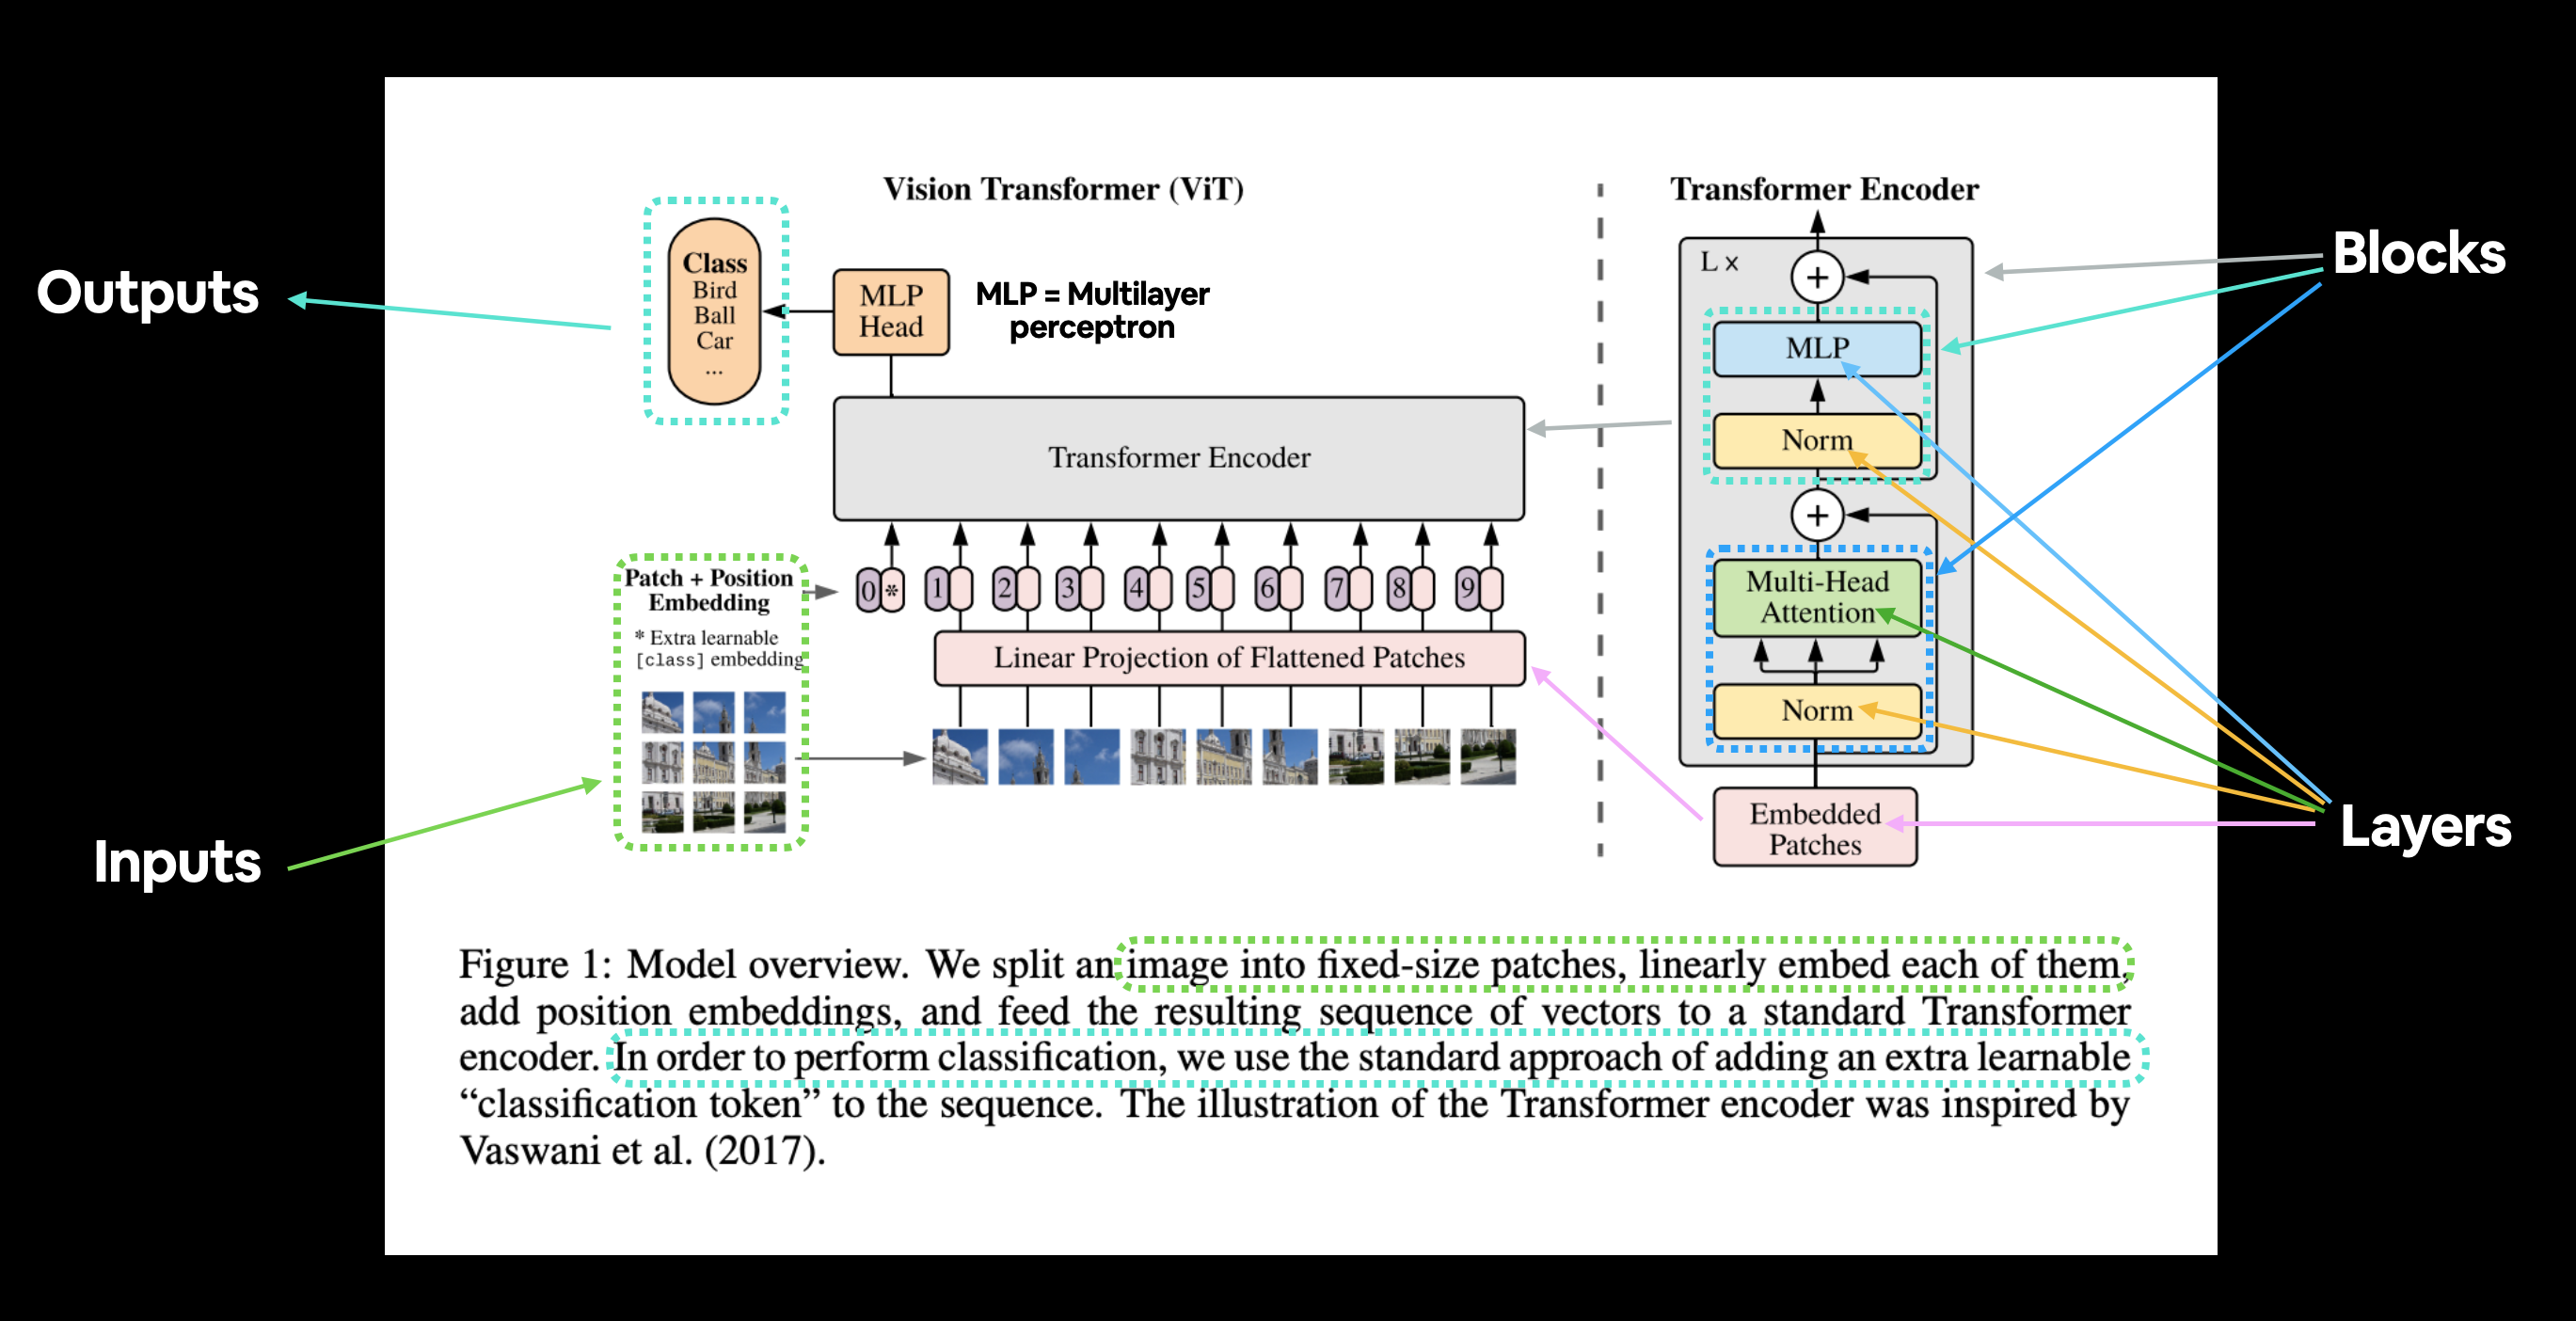

####1. MSA block : norm layer and mha layer

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

In [ ]:
# class MultiheadSelfAttentionBlock(nn.Module):
#   def __init__(self, embedding_dim: int = 768, num_heads: int =12, attn_dropout = 0):
#     super().__init__()

#     self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
#     self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim, num_heads =num_heads, dropout = attn_dropout, batch_first = True)

#   def forward(self,x):
#     x = self.layer_norm(x)
#     attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)

#     return attn_output

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiheadSelfAttentionBlock, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embedding_dim
        self.head_dim = embedding_dim // num_heads
        assert self.head_dim * num_heads == embedding_dim, "Embedding dimension must be divisible by number of heads"

        self.qkv = nn.Linear(embedding_dim, embedding_dim * 3)
        self.out = nn.Linear(embedding_dim, embedding_dim)
        self.scale = self.head_dim ** -0.5


    def forward(self, x):
        B, N, E = x.size()
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = torch.einsum('bnhd,bmhd->bnhm', q, k) * self.scale
        attn = torch.softmax(scores, dim=-1)
        out = torch.einsum('bnhm,bmhd->bnhd', attn, v).reshape(B, N, E)
        out = self.out(out)
        return out   #no norm layer,dropout


####2. MLP block : norm layer and mlp layer

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, mlp_dropout: float = 0.1):
    # Hidden Size D from Table 1 for ViT-Base
    # MLP size from Table 1 for ViT-Base = 4*embedding dim
    # Dropout from Table 3 for ViT-Base
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dim),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x



#### 3.Now adding skip connections and making the transformer block:

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_dim: int = 768, num_heads: int = 12, mlp_size:int = 3072, mlp_dropout:float = 0.1, attn_dropout: float = 0):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim, num_heads = num_heads)
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim, mlp_size = mlp_size, mlp_dropout = mlp_dropout)
    self.layer_norm_attn = nn.LayerNorm(embedding_dim)
    self.attndropout = nn.Dropout(attn_dropout)

  def forward(self, x):
    x = self.attndropout(self.msa_block(self.layer_norm_attn(x))) + x
    x = self.mlp_block(x) + x
    return x


In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

summary( model = transformer_encoder_block,
        input_size = (1,196,768),
        col_names = ["input_size","output_size","num_params","trainable"],
         col_width = 20,
         row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 196, 768]        [1, 196, 768]        --                   True
├─LayerNorm (layer_norm_attn)                      [1, 196, 768]        [1, 196, 768]        1,536                True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 196, 768]        [1, 196, 768]        --                   True
│    └─Linear (qkv)                                [1, 196, 768]        [1, 196, 2304]       1,771,776            True
│    └─Linear (out)                                [1, 196, 768]        [1, 196, 768]        590,592              True
├─Dropout (attndropout)                            [1, 196, 768]        [1, 196, 768]        --                   --
├─MLPBlock (mlp_block)                             [1, 196, 768]        [1, 196, 768]        --                   True
│    └─LayerNorm (layer_norm)                

##3. Joining all the  layers together and creating the model

Steps for making the entire VIT model:
1. Create class VIT  that inherits from nn.moudule, add in all the parameters it requires
2. assert image size and patch size, calculate number of patches, create learnable class token and posiition embedding vector layers, setup embedding dropout layer, create patch embedding
3. Create series of encoder blocks using nn.sequential
4. Create mlp head (classification)
5. Create forward() method
6. Get batch size of input, create all embeddings from the layers and expand accross batches, then concatenate and add
7. Pass them thru the layers
8. Pass index 0 of output to the mlp head and get output


In [ ]:
class VIT(nn.Module):

  def __init__(self, img_size: int = 224, in_channels: int = 3, patch_size:int = 16, num_transformer_layers: int = 12,
               embedding_dim: int = 768, mlp_size: int = 3072, num_heads: int = 12, mlp_dropout:float = 0.1, attn_dropout: float = 0,
               embedding_dropout: float = 0.1, num_classes: int = 10
               ):
    super().__init__()
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
    self.num_patches = (img_size*img_size)//patch_size**2

    ## Creating class token, positional embedding, embedding dropout
    self.class_embedding = nn.Parameter(data = torch.randn(1,1,embedding_dim), requires_grad = True)
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad = True) #for each patch we add a positional embedding
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    self.patch_embedding = PatchEmbedding( in_channels = in_channels, patch_size = patch_size, embedding_dim = embedding_dim)
    self.transformer_encoder = nn.Sequential ( *[TransformerEncoderBlock(embedding_dim = embedding_dim, num_heads = num_heads, mlp_size = mlp_size, mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim, out_features = num_classes))

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1,-1)   ## Why it is better to expand, instead of allocating batch_size in the self.class_embedin itself
    x = self.patch_embedding(x)
    x = torch.concat((class_token, x), dim = 1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:,0])  # run on each sample in a batch at 0 index
    return x


In [ ]:
from torchinfo import summary
vit = VIT()
# # Print a summary of our custom ViT model using torchinfo
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                               [32, 3, 224, 224]    [32, 10]             152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

#Creating datasets, dataloaders

In [ ]:
num_classes = 10
img_size = 32 # CIFAR-10 image size
patch_size = 8 # Smaller patch size since the image is small
embedding_dim = 128 # Adjust based on complexity; 32 might be too small
num_transformer_layers = 4  # Start with 2-4 layers for CIFAR-10
num_heads = 4  # Ensure embedding_dim is divisible by num_heads
mlp_size = 4*embedding_dim   # Adjust based on embedding_dim
mlp_dropout = 0.1
attn_dropout = 0.0
embedding_dropout = 0.1
Batch_size = 128

In [ ]:
import torchvision.transforms as transforms

IMG_SIZE = img_size

# Create transform pipeline manually
transform = torchvision.transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


print(f"Manually created transforms: {transform}")

Manually created transforms: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download= 'True', transform = transform)  ##./ means current directory
test_dataset = torchvision.datasets.CIFAR10(root = './data', train= False, download= 'True', transform = transform)


100%|██████████| 170498071/170498071 [00:03<00:00, 43798684.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Set the batch size
batch_size = Batch_size

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# class_names = train_dataset.classes

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bfb2c539780>,
 ('plane',
  'car',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'))

# Training the model

In [ ]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [ ]:
set_seeds()
epochs = 5
model = VIT(num_classes = len(class_names), img_size = img_size, num_transformer_layers = num_transformer_layers, patch_size = patch_size,
               embedding_dim = embedding_dim , mlp_size = mlp_size , num_heads = num_heads, mlp_dropout = 0.1, attn_dropout = 0,
               embedding_dropout = 0.1).to(device)

#1: using torch.max

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

def train_and_evaluate(model: torch.nn.Module,
                       train_dataloader: torch.utils.data.DataLoader,
                       test_dataloader: torch.utils.data.DataLoader,
                       epochs: int = 5,
                       device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    def train_step():
        model.train()
        train_loss, train_acc = 0.0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            train_acc += (predicted == y).sum().item() / y.size(0)

        # Average loss and accuracy per batch
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        return train_loss, train_acc

    def evaluate():
        model.eval()
        test_loss, test_acc = 0.0, 0
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                # Forward pass
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                # Accumulate loss and accuracy
                test_loss += loss.item()
                _, predicted = torch.max(y_pred, 1)
                test_acc += (predicted == y).sum().item() / y.size(0)

        # Average loss and accuracy
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc

    # Training loop
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss, train_acc = train_step()
        test_loss, test_acc = evaluate()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc
    }


epochs = 5
train_and_evaluate(model = model, train_dataloader =train_dataloader , test_dataloader =test_dataloader , device = device, epochs = 5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.7414, Train Acc: 0.3665
Test Loss: 1.4901, Test Acc: 0.4688
Epoch 2/5
Train Loss: 1.4375, Train Acc: 0.4816
Test Loss: 1.3576, Test Acc: 0.5110
Epoch 3/5
Train Loss: 1.3235, Train Acc: 0.5245
Test Loss: 1.3005, Test Acc: 0.5312
Epoch 4/5
Train Loss: 1.2426, Train Acc: 0.5535
Test Loss: 1.2683, Test Acc: 0.5392
Epoch 5/5
Train Loss: 1.1776, Train Acc: 0.5773
Test Loss: 1.2420, Test Acc: 0.5457


{'train_loss': 1.177618586193875,
 'train_acc': 0.5773177749360614,
 'test_loss': 1.2420164565496807,
 'test_acc': 0.5456882911392406}

#2 using torch.argmax as well

In [ ]:
set_seeds()
epochs = 5
model = VIT(num_classes = len(class_names), img_size = img_size, num_transformer_layers = num_transformer_layers, patch_size = patch_size,
               embedding_dim = embedding_dim , mlp_size = mlp_size , num_heads = num_heads, mlp_dropout = 0.1, attn_dropout = 0,
               embedding_dropout = 0.1).to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / y.size(0)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=nn.CrossEntropyLoss(),
                epochs=5)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7414 | train_acc: 0.3665 | test_loss: 1.4901 | test_acc: 0.4688
Epoch: 2 | train_loss: 1.4375 | train_acc: 0.4816 | test_loss: 1.3576 | test_acc: 0.5104
Epoch: 3 | train_loss: 1.3238 | train_acc: 0.5236 | test_loss: 1.3067 | test_acc: 0.5218
Epoch: 4 | train_loss: 1.2411 | train_acc: 0.5539 | test_loss: 1.2522 | test_acc: 0.5471
Epoch: 5 | train_loss: 1.1758 | train_acc: 0.5795 | test_loss: 1.2316 | test_acc: 0.5577


#Additonal

In [ ]:

### doubt on transforms
### set up the training, testing code,
###train, see your accuracy, plot and test for an image

In [ ]:
## clear your conceptual doubts

#MNIST DATASET

In [ ]:
num_classes = 10
img_size = 28 # CIFAR-10 image size
patch_size = 7 # Smaller patch size since the image is small
embedding_dim = 64 # Adjust based on complexity; 32 might be too small
num_transformer_layers = 4  # Start with 2-4 layers for CIFAR-10
num_heads = 2  # Ensure embedding_dim is divisible by num_heads
mlp_size = 4*embedding_dim   # Adjust based on embedding_dim
mlp_dropout = 0.1
attn_dropout = 0.0
embedding_dropout = 0.1
Batch_size = 128
in_channels = 1

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

In [ ]:
IMG_SIZE = img_size
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST normalization
])

# MNIST datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seeds()
epochs = 15
model = VIT(num_classes = len(class_names), img_size = img_size, num_transformer_layers = num_transformer_layers, patch_size = patch_size,
               embedding_dim = embedding_dim , mlp_size = mlp_size , num_heads = num_heads, mlp_dropout = 0.1, attn_dropout = 0,
               embedding_dropout = 0.1, in_channels = in_channels).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchinfo import summary
vit = VIT()
# # Print a summary of our custom ViT model using torchinfo
summary(model=vit,
        input_size=(128, 1, 28, 28), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
train_and_evaluate(model = model, train_dataloader =train_loader , test_dataloader =test_loader , device = device, epochs = 15)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15
Train Loss: 0.6630, Train Acc: 0.7820
Test Loss: 0.2344, Test Acc: 0.9287
Epoch 2/15
Train Loss: 0.2338, Train Acc: 0.9284
Test Loss: 0.1438, Test Acc: 0.9589
Epoch 3/15
Train Loss: 0.1681, Train Acc: 0.9492
Test Loss: 0.1258, Test Acc: 0.9604
Epoch 4/15
Train Loss: 0.1371, Train Acc: 0.9581
Test Loss: 0.1057, Test Acc: 0.9685
Epoch 5/15
Train Loss: 0.1161, Train Acc: 0.9642
Test Loss: 0.0962, Test Acc: 0.9705
Epoch 6/15
Train Loss: 0.1056, Train Acc: 0.9678
Test Loss: 0.0952, Test Acc: 0.9683
Epoch 7/15
Train Loss: 0.0915, Train Acc: 0.9717
Test Loss: 0.0926, Test Acc: 0.9725
Epoch 8/15
Train Loss: 0.0853, Train Acc: 0.9736
Test Loss: 0.0706, Test Acc: 0.9784
Epoch 9/15
Train Loss: 0.0774, Train Acc: 0.9759
Test Loss: 0.0821, Test Acc: 0.9757
Epoch 10/15
Train Loss: 0.0733, Train Acc: 0.9768
Test Loss: 0.0676, Test Acc: 0.9788
Epoch 11/15
Train Loss: 0.0693, Train Acc: 0.9785
Test Loss: 0.0611, Test Acc: 0.9809
Epoch 12/15
Train Loss: 0.0662, Train Acc: 0.9786
Test Loss: 0.

{'train_loss': 0.053442055357497,
 'train_acc': 0.9833033493248045,
 'test_loss': 0.05884796749473302,
 'test_acc': 0.981309335443038}